# G2M Cab Investment Insight Exploratory Data Analysis

## Introduction

XYZ is a private firm in US. Due to remarkable growth in the Cab Industry in last few years and multiple key players in the market, it is planning for an investment in Cab industry and as per their Go-to-Market(G2M) strategy they want to understand the market before taking final decision.

There will be two cab companies, yellow and pink, working across several cities in the US, and the data sets with customer and transaction information. The time period of the data is from 2016/01/31 to 2018/12/31. We aim to make a recommendation to XYZ on which company they should invest in by performing exploratory data analysis (EDA) on the provided datasets and then answer the following questions:

- Which company has maximum cab users at a particular time period?
- Which company makes the most profit from time to time?
- Is there a significant difference in customer gender?
- What kind of income level take cab more often?
- Is there a difference in customer age?
- Which company has a better return frequency?
- Is there a seasonality trend in the data?
- Which distance travelled has the most customer?
- Which company is likely to perform better in the future?

## Import Libraries and Data

In [240]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import xlrd
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

2023-06-21 20:18:51.591390: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [197]:
cab = pd.read_csv("Cab_Data.csv")
customer = pd.read_csv("Customer_ID.csv")
transaction = pd.read_csv("Transaction_ID.csv")
city = pd.read_csv("City.csv")

dataframes = {'Cab':cab, 'Customer ID':customer,'Transaction ID':transaction,'City':city}

for name, df in dataframes.items():
    print( f'\n {name} details')
    print(df.info())



 Cab details
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359392 entries, 0 to 359391
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Transaction ID  359392 non-null  int64  
 1   Date of Travel  359392 non-null  int64  
 2   Company         359392 non-null  object 
 3   City            359392 non-null  object 
 4   KM Travelled    359392 non-null  float64
 5   Price Charged   359392 non-null  float64
 6   Cost of Trip    359392 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 19.2+ MB
None

 Customer ID details
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49171 entries, 0 to 49170
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Customer ID         49171 non-null  int64 
 1   Gender              49171 non-null  object
 2   Age                 49171 non-null  int64 
 3   Income (USD/Month) 

    From the details we can notice that there are no missing values, the data is complete and does not contain any missing value.

## Data Cleaning

Next, we start the data cleaning process.

In [198]:
#check unique values
cab_uno = cab.drop_duplicates().shape[0]
customer_uno = customer.drop_duplicates().shape[0]
transaction_uno = transaction.drop_duplicates().shape[0]
print(f'There are {cab_uno} unique cab data')
print(f'There are {customer_uno} unique Customer ID')
print(f'There are {transaction_uno} unique Transaction ID')

There are 359392 unique cab data
There are 49171 unique Customer ID
There are 440098 unique Transaction ID


### Merge all data to main dataframe

In [199]:
#inner merge
merge_cab = pd.merge(cab, transaction, on='Transaction ID')
data = pd.merge(merge_cab, customer, on='Customer ID', how = 'left')
data = pd.merge(data, city, on='City', how = 'left')

display(data.head())

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),Population,Users
0,10000011,42377,Pink Cab,ATLANTA GA,30,371,314,29290,Card,Male,28,10813,"814,885","24,701"
1,10000012,42375,Pink Cab,ATLANTA GA,29,359,335,27703,Card,Male,27,9237,"814,885","24,701"
2,10000013,42371,Pink Cab,ATLANTA GA,9,125,98,28712,Cash,Male,53,11242,"814,885","24,701"
3,10000014,42376,Pink Cab,ATLANTA GA,33,377,352,28020,Cash,Male,23,23327,"814,885","24,701"
4,10000015,42372,Pink Cab,ATLANTA GA,9,115,98,27182,Card,Male,33,8536,"814,885","24,701"


After inspecting the data above, we have 2 things to do. Reformat the _Date of Travel_ column, and remove , in the numbers for population and users.

In [200]:
data['Population'] = data['Population'].str.replace(',', '').astype(float)
data['Users'] = data['Users'].str.replace(',', '').astype(float)

In [201]:
date = []

for i in range(len(data)):
    date_list = xlrd.xldate_as_tuple(data['Date of Travel'].iloc[i],0)
    date.append(datetime(*date_list))

data['Date of Travel'] = date
data['Date of Travel'].describe()    

/var/folders/1f/jl4ws2hd35s8hqzrng2b9b600000gn/T/ipykernel_70489/1796793056.py:8: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data['Date of Travel'].describe()


count                  359392
unique                   1095
top       2018-01-05 00:00:00
freq                     2022
first     2016-01-02 00:00:00
last      2018-12-31 00:00:00
Name: Date of Travel, dtype: object

    As shown above, the starting date is 2016-01-02, but the designated time period is from 2016/01/31 to 2018/12/31. Therefore, we need to toss out some rows.

In [202]:
start_date = datetime(2016,1,31)
data = data[data['Date of Travel'] >= start_date]
data['Year'] = data['Date of Travel'].dt.year

data['Date of Travel'].describe(datetime_is_numeric=True)

count                           355032
mean     2017-08-24 04:07:05.390387712
min                2016-01-31 00:00:00
25%                2016-12-01 00:00:00
50%                2017-09-15 00:00:00
75%                2018-05-17 00:00:00
max                2018-12-31 00:00:00
Name: Date of Travel, dtype: object

## Start EDA

After finishing the cleaning part, we can dive into the data and start doing some analysis!

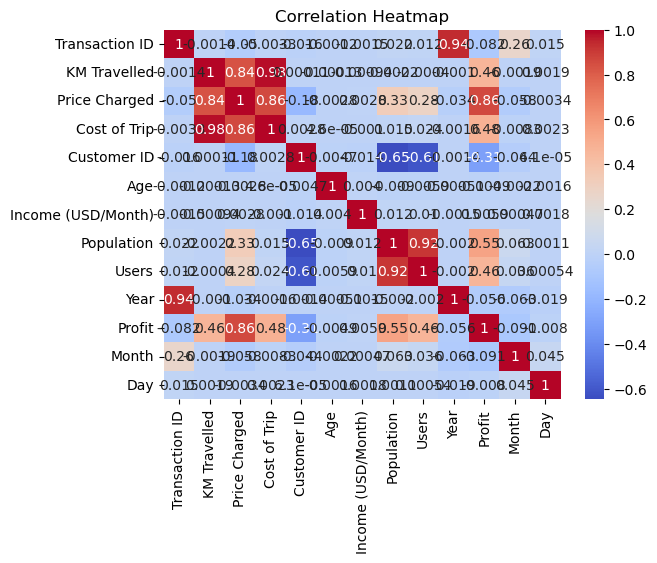

In [243]:
correlation_matrix = data.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

plt.title('Correlation Heatmap')
plt.show()

From the correlation map above, we can observe that:
* Cost of Trip to KM Travelled
* Cost of Trip to Price Charged
* Price Charged to KM Travelled
* Users to Population

### Which company has maximum cab users at a particular time period?

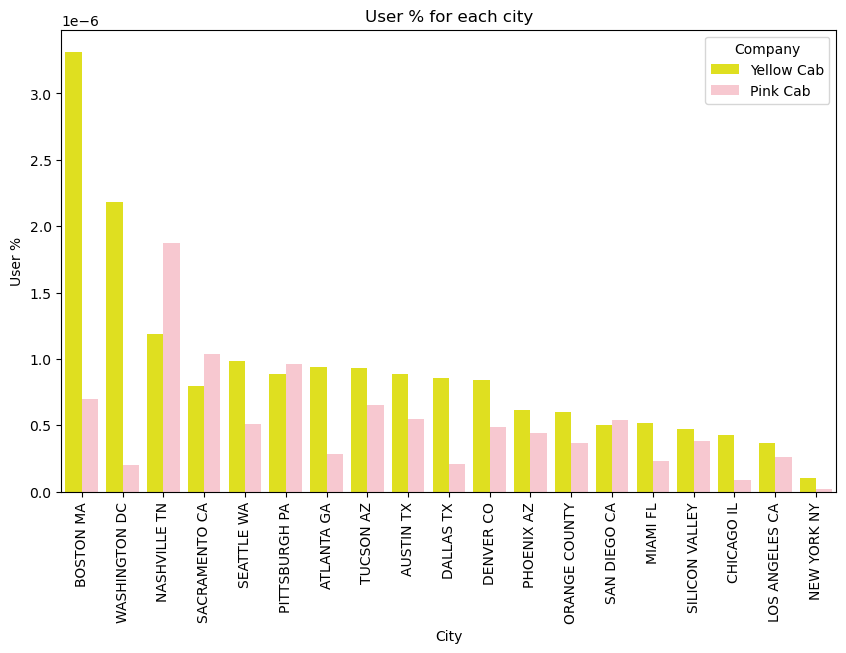

In [204]:
#city user percentage
user_percentage = data.groupby(['City', 'Company'])['Users'].count() / data.groupby('City')['Population'].sum()
user_percentage = user_percentage.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='City', y=user_percentage.values, hue='Company', data=user_percentage.reset_index(), palette=['yellow', 'pink'])
plt.xlabel('City')
plt.ylabel('User %')
plt.title('User % for each city')
plt.xticks(rotation=90)

plt.show()

Yellow Cab Company has more percentage of users in almost every cities, except for:

* Nashville TN
* Sacremento CA
* Pittsburgh PA
* San Diego CA

### Which company makes the most profit from time to time?

In [205]:
#Total difference
#chart overview
data['Profit'] = data['Price Charged'] - data['Cost of Trip']

mean_profit = data.groupby('Company').agg({'Transaction ID': 'count', 'Profit': 'sum'})
mean_profit = mean_profit.rename(columns={'Transaction ID': 'Total Rides', 'Profit':'Total Profit'})
mean_profit['Profit Per Ride'] = mean_profit['Total Profit']/mean_profit['Total Rides']
mean_profit['Total Profit'] = mean_profit['Total Profit'].apply(lambda x: "{:.0f}".format(x))
mean_profit['Bad Trip'] = data[data['Profit'] < 0].groupby('Company')['Profit'].count()
mean_profit['Bad Trip %'] = mean_profit['Bad Trip']/mean_profit['Total Rides']

mean_profit


,Total Rides,Total Profit,Profit Per Ride,Bad Trip,Bad Trip %
Company,,,,,
Pink Cab,83825,5237540,62,10989,0
Yellow Cab,271207,43251775,159,13669,0


From the table above, we can see that the Yellow Cab Company has made more profit, and has a higher Profit Per Ride. Furthermore, the Yellow Cab Company also has a lower chance for a bad trip, which is a trip without profit.

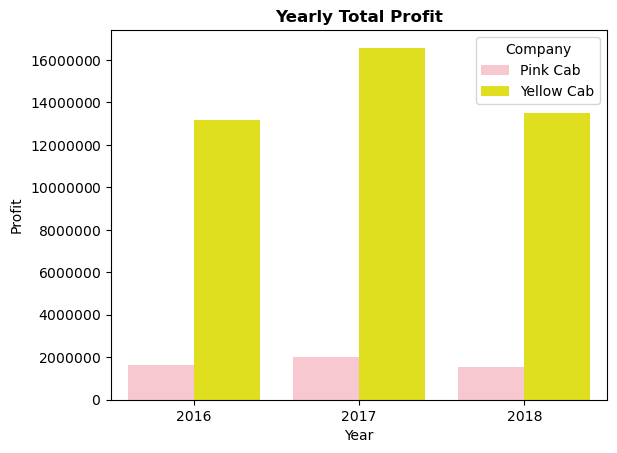

In [206]:
#profit year
year_profit = data.groupby(['Company', 'Year'])['Profit'].sum().reset_index()

sns.barplot(x='Year', y='Profit', hue='Company', data=year_profit, palette=['pink', 'yellow'])
plt.xlabel('Year')
plt.ylabel('Profit')
plt.title('Yearly Total Profit', weight='bold')
plt.ticklabel_format(style='plain', axis='y', useMathText=True)
plt.show()

From the plot above, we can notice that both companies follow a trend increaseing profit in 2017 and returning back in 2018.

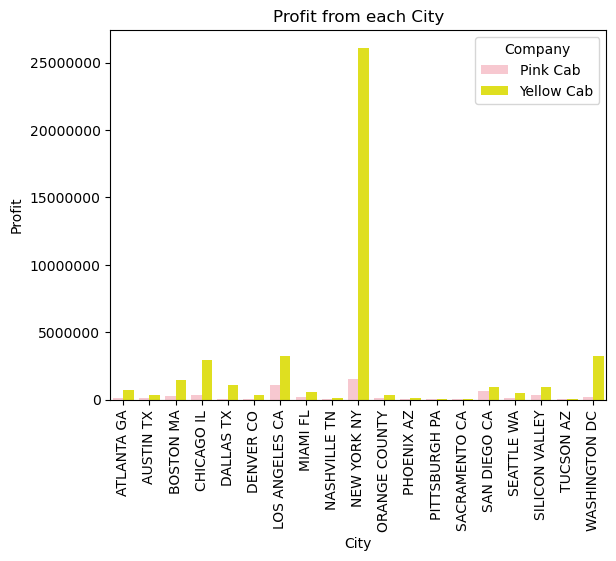

Company         Pink Cab  Yellow Cab
City                                
ATLANTA GA        94,789     726,112
AUSTIN TX        147,036     373,479
BOSTON MA        259,418   1,466,082
CHICAGO IL       311,648   2,971,715
DALLAS TX         25,058   1,077,692
DENVER CO         40,706     348,371
LOS ANGELES CA 1,100,678   3,202,163
MIAMI FL         161,563     590,044
NASHVILLE TN      63,302      83,407
NEW YORK NY    1,502,739  26,114,481
ORANGE COUNTY    100,716     349,126
PHOENIX AZ        34,492     154,549
PITTSBURGH PA     16,874      66,324
SACRAMENTO CA     53,265      58,726
SAN DIEGO CA     627,637     927,762
SEATTLE WA       112,710     473,234
SILICON VALLEY   335,091     959,744
TUCSON AZ         58,736      79,346
WASHINGTON DC    191,083   3,229,419


In [207]:
#city profit
city_profit = data.groupby(['Company', 'City'])['Profit'].sum().reset_index()

sns.barplot(x='City', y='Profit', hue='Company', data=city_profit, palette=['pink', 'yellow'])
plt.xlabel('City')
plt.ylabel('Profit')
plt.title('Profit from each City')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)
plt.show()

pivot_table = pd.pivot_table(city_profit, values='Profit', index='City', columns='Company', fill_value=0)
pd.options.display.float_format = '{:,.0f}'.format
print(pivot_table)

The Yellow Cab Company has higher profit in all cities, especially in _Chicago IL_, _Los Angeles CA_, _New York NY_, and _Washington DC_.

### Is there a significant difference in customer gender?

/var/folders/1f/jl4ws2hd35s8hqzrng2b9b600000gn/T/ipykernel_70489/2309661156.py:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  gender_percentage = gender.groupby('Company')['Total'].apply(lambda x: x / x.sum() * 100)


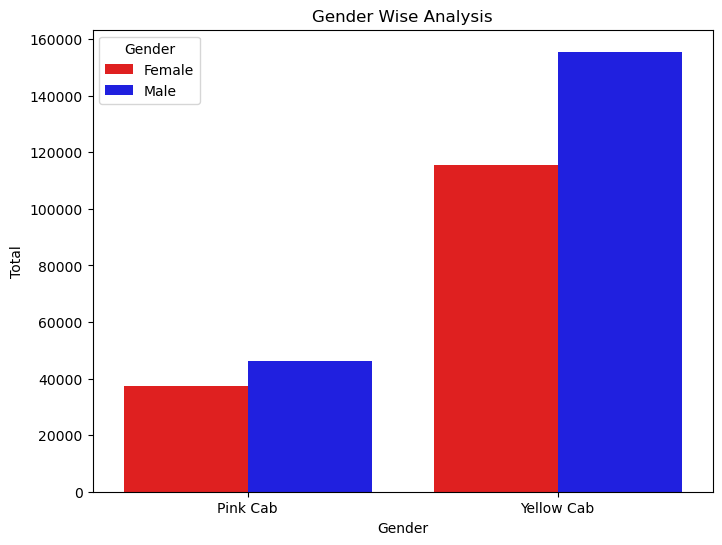

In [208]:
gender = data.groupby(['Company', 'Gender'])['Transaction ID'].count().reset_index()
gender = gender.rename(columns={'Transaction ID': 'Total'})

gender_percentage = gender.groupby('Company')['Total'].apply(lambda x: x / x.sum() * 100)

plt.figure(figsize=(8, 6))
ax1 = sns.barplot(x='Company', y='Total', hue='Gender', data=gender, palette=['red', 'blue'])
plt.xlabel('Gender')
plt.ylabel('Total')
plt.title('Gender Wise Analysis')


plt.show()

Both company have slighly more Male customer than Female customer. There isn't a big difference.

### What kind of income level takes a cab more often?

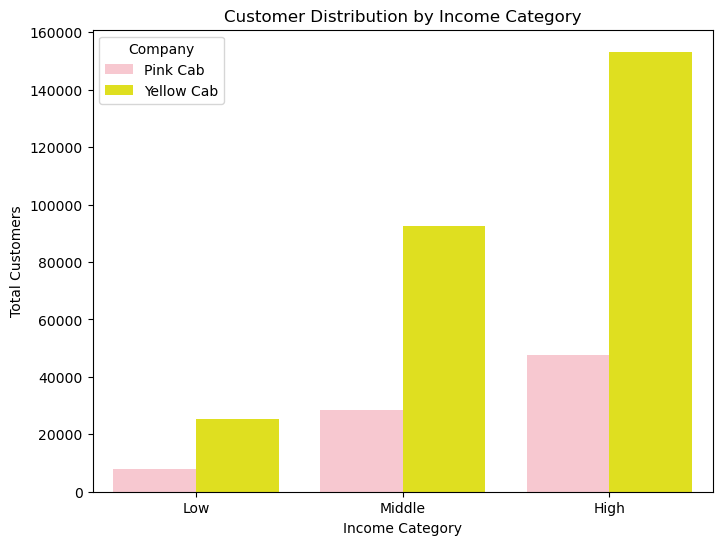

Income Category  Low  Middle  High
Company                           
Pink Cab           9      34    57
Yellow Cab         9      34    57


In [209]:
#customer income
#income status:  0~4350~13050 as Low, Middle, High

income_ranges = [0, 4350, 13050, np.inf]
income_labels = ['Low', 'Middle', 'High']
data['Income Category'] = pd.cut(data['Income (USD/Month)'], bins=income_ranges, labels=income_labels, right=False)

customer_groups = data.groupby(['Company', 'Income Category'])['Customer ID'].count().reset_index()
customer_groups = customer_groups.rename(columns={'Customer ID': 'Total Customers'})

plt.figure(figsize=(8, 6))
sns.barplot(x='Income Category', y='Total Customers', hue='Company', data=customer_groups, palette=['pink', 'yellow'])
plt.xlabel('Income Category')
plt.ylabel('Total Customers')
plt.title('Customer Distribution by Income Category')
plt.show()

pivot_table = customer_groups.pivot_table(index='Company', columns='Income Category', values='Total Customers', aggfunc='sum')
total_customers = pivot_table.sum(axis=1)
pivot_table_percentage = pivot_table.div(total_customers, axis=0) * 100
print(pivot_table_percentage)

The percentage for both companies are the same, and High income, which are people earning more than 13050 per month, takes the cab more often.

### Is there a difference in customer age?

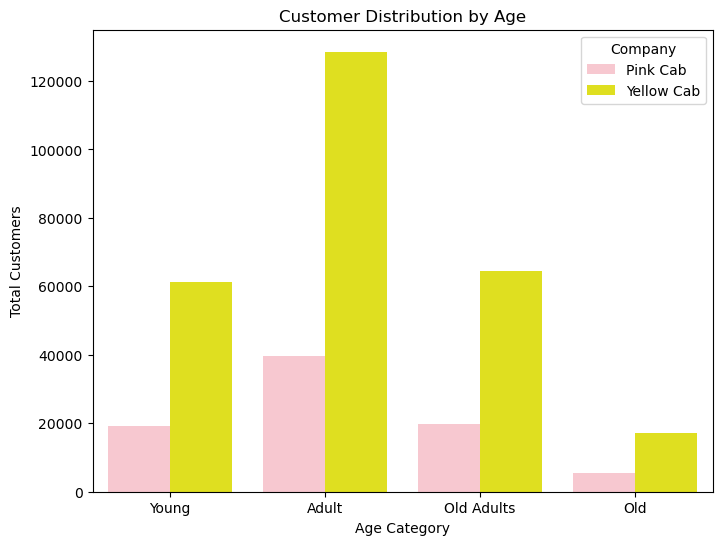

In [210]:
#company age gender
#18-25, 26-40, 41-60, 60+
age_ranges = [18, 25, 40, 60, np.inf]
age_labels = ['Young', 'Adult', 'Old Adults', 'Old']
data['Age Category'] = pd.cut(data['Age'], bins=age_ranges, labels=age_labels, right=False)

age_groups = data.groupby(['Company', 'Age Category'])['Customer ID'].count().reset_index()
age_groups = age_groups.rename(columns={'Customer ID': 'Total Customers'})

plt.figure(figsize=(8, 6))
sns.barplot(x='Age Category', y='Total Customers', hue='Company', data=age_groups, palette=['pink', 'yellow'])
plt.xlabel('Age Category')
plt.ylabel('Total Customers')
plt.title('Customer Distribution by Age')

plt.show()

Adults are the people aged from 26 to 40 years old, and they are the majority group taking a cab.

### Which company has a better return frequency?

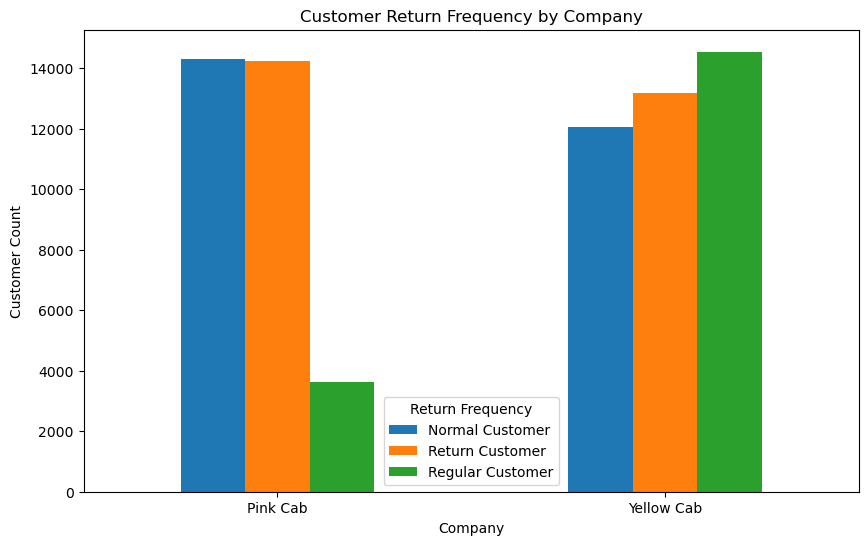

Return Frequency  Normal Customer  Return Customer  Regular Customer
Company                                                             
Pink Cab                    14317            14239              3618
Yellow Cab                  12044            13167             14544


In [211]:

customer_counts = data.groupby(['Company', 'Customer ID']).size().reset_index(name='Count')

customer_counts['Return Frequency'] = pd.cut(customer_counts['Count'],
                                             bins=[0, 1, 5, float('inf')],
                                             labels=['Normal Customer', 'Return Customer', 'Regular Customer'])

return_frequency_counts = customer_counts.groupby(['Company', 'Return Frequency']).size().reset_index(name='Customer Count')
return_frequency_pivot = return_frequency_counts.pivot(index='Company', columns='Return Frequency', values='Customer Count')
return_frequency_pivot.fillna(0, inplace=True)
return_frequency_pivot.plot(kind='bar', figsize=(10, 6),)

plt.xlabel('Company')
plt.ylabel('Customer Count')
plt.title('Customer Return Frequency by Company')
plt.xticks(rotation=0)
plt.show()

print(return_frequency_pivot)

From the plot above, we can see that the Pink Cab Company has better performance in Normal customer and Reutrn Customer, while as the Yellow Cab Company has 4 times more regular customers, this might be the reason there is such a big difference in profit.

### Is there a seasonality trend?

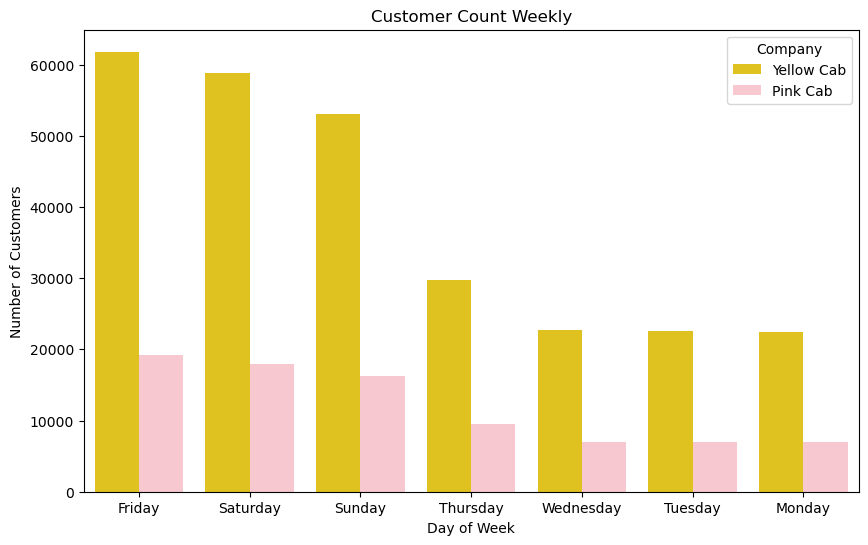

In [212]:
data['Week'] = data['Date of Travel'].dt.day_name()
week_count = data.groupby(['Company', 'Week'])['Transaction ID'].count().reset_index()
week_count = week_count.sort_values( 'Transaction ID', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Week', y='Transaction ID', hue='Company', data=week_count, 
             palette=['#FFD700', 'pink'], linewidth = 3)
plt.xlabel('Day of Week')
plt.ylabel('Number of Customers')
plt.title('Customer Count Weekly')
plt.show()


From the plot above, we notice that most customer take cabs on _Friday_, _Saturday_, and _Sunday_.

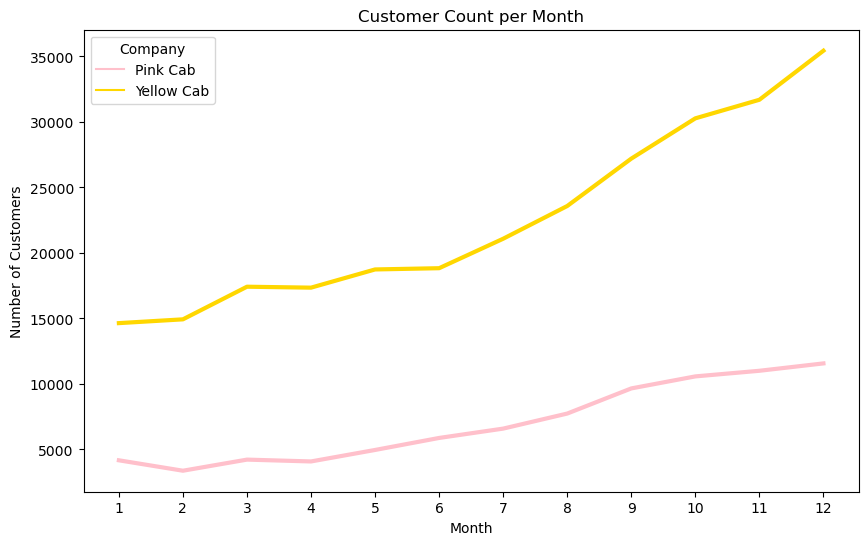

In [213]:
#monthly pattern
data['Month'] = data['Date of Travel'].dt.month

monthly_count = data.groupby(['Company', 'Month'])['Customer ID'].count().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='Month', y='Customer ID', hue='Company', data=monthly_count, 
             palette=['pink', '#FFD700'], linewidth = 3)
plt.xlabel('Month')
plt.ylabel('Number of Customers')
plt.title('Customer Count per Month')
plt.xticks(range(1, 13))
plt.show()

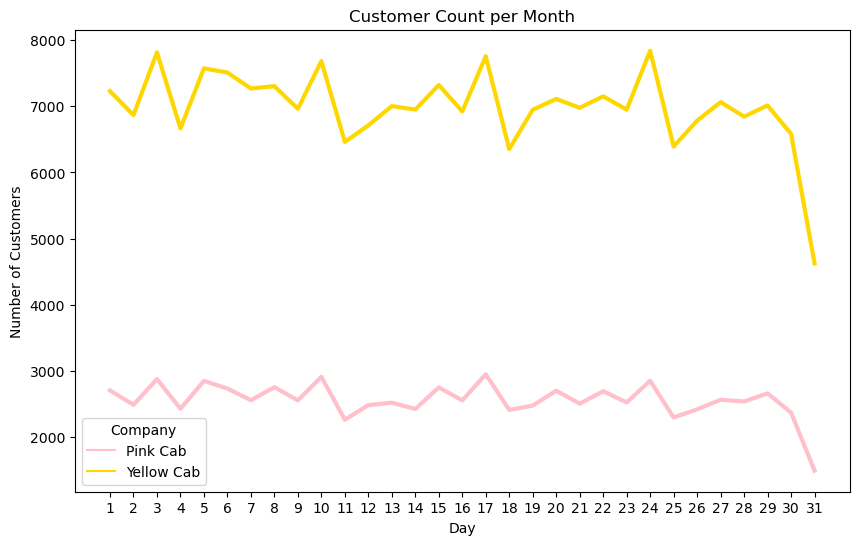

In [214]:
#daily pattern
data['Day'] = data['Date of Travel'].dt.day
day_count = data.groupby(['Company', 'Day'])['Customer ID'].nunique().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='Day', y='Customer ID', hue='Company', data=day_count, 
             palette=['pink', '#FFD700'], linewidth = 3)
plt.xlabel('Day')
plt.ylabel('Number of Customers')
plt.title('Customer Count per Month')
plt.xticks(range(1, 32))
plt.show()

From the monthly pattern, we can see that more people takes a cab during the second half of the year.
From the daily pattern, we can see that the pattern repeats every 7 days, and also has a decrease when it comes to the end of the month.


### Which distance travelled has the most customer?

Text(0.5, 1.0, 'Customer Distribution by Travelled Distance')

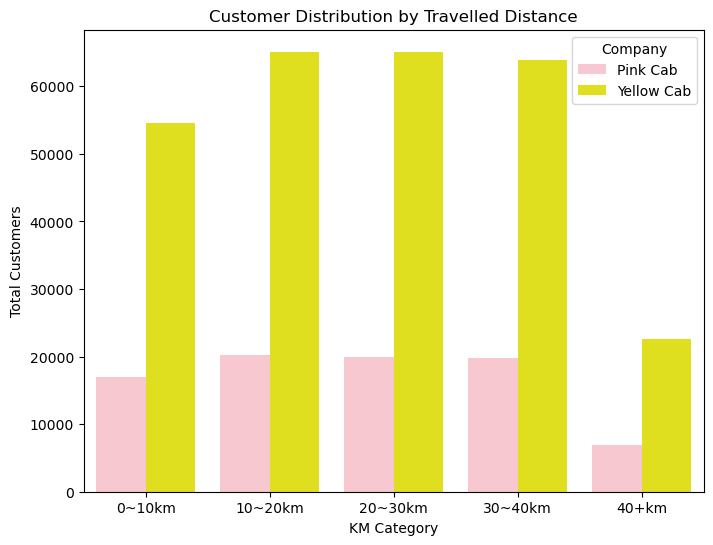

In [215]:
#customer distance
km_ranges = [0, 10, 20, 30, 40, np.inf]
km_labels = ['0~10km', '10~20km', '20~30km', '30~40km', '40+km']
data['KM Category'] = pd.cut(data['KM Travelled'], bins=km_ranges, labels=km_labels, right=False)

km_groups = data.groupby(['Company', 'KM Category'])['Customer ID'].count().reset_index()
km_groups = km_groups.rename(columns={'Customer ID': 'Total Customers'})

plt.figure(figsize=(8, 6))
sns.barplot(x='KM Category', y='Total Customers', hue='Company', data=km_groups, palette=['pink', 'yellow'])
plt.xlabel('KM Category')
plt.ylabel('Total Customers')
plt.title('Customer Distribution by Travelled Distance')



Most people take a cab to travel from 10km to 40km.

### Which company is likely to perform better in the future?

In [267]:
yellow_predict = data[data['Company']== 'Yellow Cab']
yellow_predict = yellow_predict[['Date of Travel','Profit']]
yellow_predict = yellow_predict.groupby('Date of Travel')['Profit'].sum().reset_index()                           
yellow_predict.index = yellow_predict['Date of Travel']

#just to check if the data is right
#plt.scatter(yellow_predict['Date of Travel'],yellow_predict['Profit'], label = 'Profit')
    
scaler = MinMaxScaler(feature_range=(0,1))    
yellow_predict.drop('Date of Travel',axis=1,inplace=True)
final_data_y = yellow_predict.values
train_data_y=final_data_y[0:800,:]
valid_data_y=final_data_y[800:,:]
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data_y=scaler.fit_transform(final_data_y)
x_train_data_y,y_train_data_y=[],[]
for i in range(800,len(train_data_y)):
    x_train_data_y.append(scaled_data_y[i-60:i,0])
    y_train_data_y.append(scaled_data_y[i,0])
    

lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(np.shape(x_train_data_y)[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
model_data_y=yellow_predict[len(yellow_predict)-len(valid_data_y)-60:].values
model_data_y=model_data_y.reshape(-1,1)
model_data_y=scaler.transform(model_data_y)

x_train_data_y = np.array(x_train_data_y)
y_train_data_y = np.array(y_train_data_y)



lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data_y,y_train_data_y,epochs=1,batch_size=1,verbose=2)
X_test=[]
for i in range(800,model_data_y.shape[0]):
    X_test.append(model_data_y[i-800:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

IndexError: tuple index out of range

In [264]:
if len(X_test.shape) < 2:
    X_test = np.reshape(X_test, (X_test.shape[0], 1))
else:
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [261]:
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data_y,y_train_data_y,epochs=1,batch_size=1,verbose=2)
X_test=[]
for i in range(60,model_data_y.shape[0]):
    X_test.append(model_data_y[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

predict_y=lstm_model.predict(X_test)
predict_y=scaler.inverse_transform(predict_y)

train_data_y=data[:800]
valid_data_y=data[800:]
valid_data_y['Predictions']=predict_y
plt.plot(train_data_y["Profit"])
plt.plot(valid_data_y[['Profit',"Predictions"]])

ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'numpy.ndarray'>"}), (<class 'list'> containing values of types {"<class 'numpy.float64'>"})

In [250]:
yellow_predict = data[data['Company'] == 'Yellow Cab']
yellow_predict = yellow_predict[['Date of Travel', 'Profit']]
yellow_predict = yellow_predict.groupby('Date of Travel')['Profit'].sum().reset_index()
yellow_predict.index = yellow_predict['Date of Travel']

# Prepare data for LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))
yellow_predict.drop('Date of Travel', axis=1, inplace=True)
final_data_y = yellow_predict.values
train_data_y = final_data_y[:800, :]
valid_data_y = final_data_y[800:, :]
scaled_data_y = scaler.fit_transform(final_data_y)
x_train_data_y, y_train_data_y = [], []
for i in range(60, len(train_data_y)):
    x_train_data_y.append(scaled_data_y[i - 60:i, 0])
    y_train_data_y.append(scaled_data_y[i, 0])

# Convert data to numpy arrays
x_train_data_y = np.array(x_train_data_y)
y_train_data_y = np.array(y_train_data_y)

# Reshape input data for LSTM
x_train_data_y = np.reshape(x_train_data_y, (x_train_data_y.shape[0], x_train_data_y.shape[1], 1))

# Create the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=266, return_sequences=True, input_shape=(x_train_data_y.shape[1], 1)))
lstm_model.add(LSTM(units=266))
lstm_model.add(Dense(1))

# Compile and train the model
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(x_train_data_y, y_train_data_y, epochs=1, batch_size=1, verbose=2)

# Prepare test data for prediction
model_data_y = yellow_predict[len(yellow_predict) - len(valid_data_y) - 60:].values
model_data_y = model_data_y.reshape(-1, 1)
model_data_y = scaler.transform(model_data_y)
X_test = []
for i in range(60, model_data_y.shape[0]):
    X_test.append(model_data_y[i - 60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions
predict_y = lstm_model.predict(X_test)
predict_y = scaler.inverse_transform(predict_y)

# Prepare data for plotting
train_data_y = data[:800]
valid_data_y = data[800:]
valid_data_y['Predictions'] = predict_y

plt.plot(train_data_y.index, train_data_y['Profit'])
plt.plot(valid_data_y.index, valid_data_y['Profit'])
plt.plot(valid_data_y.index, valid_data_y['Predictions'])
plt.legend(['Train', 'Actual', 'Predictions'])
plt.xlabel('Date of Travel')
plt.ylabel('Profit')
plt.title('Yellow Cab Profit Prediction')
plt.show()

2023-06-21 21:21:03.383316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-21 21:21:03.385327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-21 21:21:03.387286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

740/740 - 50s - loss: 0.0194 - 50s/epoch - 68ms/step


2023-06-21 21:21:53.918555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-21 21:21:53.920260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-21 21:21:53.922079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 [==============================] - 1s 88ms/step


ValueError: Length of values (266) does not match length of index (354232)

In [224]:
test = yellow_predict.groupby('Date of Travel')['Profit'].sum().reset_index()
print(test)


     Date of Travel  Profit
0        2016-01-31  67,710
1        2016-02-01  17,278
2        2016-02-02  17,051
3        2016-02-03  12,881
4        2016-02-04  25,488
...             ...     ...
1061     2018-12-27  28,058
1062     2018-12-28 100,411
1063     2018-12-29  98,814
1064     2018-12-30  19,574
1065     2018-12-31  17,788

[1066 rows x 2 columns]


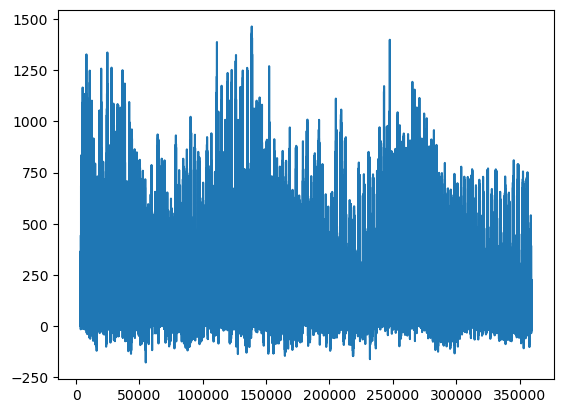

In [222]:
plt.plot(yellow_predict['Profit'],label = 'Profit')

In [217]:


# Prepare the data and split into features and target variables
X = data[['Feature1', 'Feature2', ...]]  # Features that influence profit
y_yellow_cab = data['Yellow_Cab_Profit']
y_pink_cab = data['Pink_Cab_Profit']

# Split the data into training and testing sets
X_train, X_test, y_train_yellow_cab, y_test_yellow_cab, y_train_pink_cab, y_test_pink_cab = train_test_split(
    X, y_yellow_cab, y_pink_cab, test_size=0.2, random_state=42)

# Create and train the linear regression model for Yellow Cab
yellow_cab_model = LinearRegression()
yellow_cab_model.fit(X_train, y_train_yellow_cab)

# Make predictions for Yellow Cab
y_pred_yellow_cab = yellow_cab_model.predict(X_test)

# Evaluate the model for Yellow Cab
mse_yellow_cab = mean_squared_error(y_test_yellow_cab, y_pred_yellow_cab)
print(f"Yellow Cab MSE: {mse_yellow_cab}")

# Create and train the linear regression model for Pink Cab
pink_cab_model = LinearRegression()
pink_cab_model.fit(X_train, y_train_pink_cab)

# Make predictions for Pink Cab
y_pred_pink_cab = pink_cab_model.predict(X_test)

# Evaluate the model for Pink Cab
mse_pink_cab = mean_squared_error(y_test_pink_cab, y_pred_pink_cab)
print(f"Pink Cab MSE: {mse_pink_cab}")


KeyError: "None of [Index(['Feature1', 'Feature2', Ellipsis], dtype='object')] are in the [columns]"

## Recommendation

To summarize, here are some insights from the analysis:

- Yellow Cab company has more percentage of users in most of the cities except for 4
- Yellow Cab company has earned <b>8.25</b> times more profit in total than the Pink Cab company
- Yellow Cab company made <b>2.55</b> times more profit per ride than the Pink Cab company
- Yellow Cab company has <b>38%</b> less non-profit trips than the Pink Cab company
- The Yellow Cab company has <b>4</b> times more regular customers than the Pink Cab company


Based on our analysis, we recommend <b>Yellow Cab</b> for investment.